In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'click',
    'flip',
    'click2'
]

data = np.concatenate([
    np.load('seq_click_1636092994.npy'),
    np.load('seq_click_1636093126.npy'),
    np.load('seq_click_1636093269.npy'),
    np.load('seq_click_1636463271.npy'),

    np.load('seq_flip_1636092994.npy'),
    np.load('seq_flip_1636093126.npy'),
    np.load('seq_flip_1636093269.npy'),
    np.load('seq_flip_1636463271.npy'),
    
    np.load('seq_click2_1636092994.npy'),
    np.load('seq_click2_1636093126.npy'),
    np.load('seq_click2_1636093269.npy'),
    np.load('seq_click2_1636463271.npy'),

], axis=0)

data.shape

(13656, 30, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(13656, 30, 99)
(13656,)


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(13656, 3)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(12290, 30, 99) (12290, 3)
(1366, 30, 99) (1366, 3)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape = x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
384/385 [============================>.] - ETA: 0s - loss: 7.8883 - acc: 0.4682
Epoch 00001: val_acc improved from -inf to 0.55490, saving model to models/model.h5
385/385 [==============================] - 9s 20ms/step - loss: 7.8871 - acc: 0.4682 - val_loss: 1.9503 - val_acc: 0.5549 - lr: 0.0010
Epoch 2/200
385/385 [==============================] - ETA: 0s - loss: 2.3375 - acc: 0.4999
Epoch 00002: val_acc did not improve from 0.55490
385/385 [==============================] - 7s 19ms/step - loss: 2.3375 - acc: 0.4999 - val_loss: 1.4426 - val_acc: 0.5176 - lr: 0.0010
Epoch 3/200
384/385 [============================>.] - ETA: 0s - loss: 1.3940 - acc: 0.5353
Epoch 00003: val_acc did not improve from 0.55490
385/385 [==============================] - 7s 19ms/step - loss: 1.3938 - acc: 0.5354 - val_loss: 1.4900 - val_acc: 0.4956 - lr: 0.0010
Epoch 4/200
384/385 [============================>.] - ETA: 0s - loss: 1.2728 - acc: 0.5077
Epoch 00004: val_acc did not improve from 0

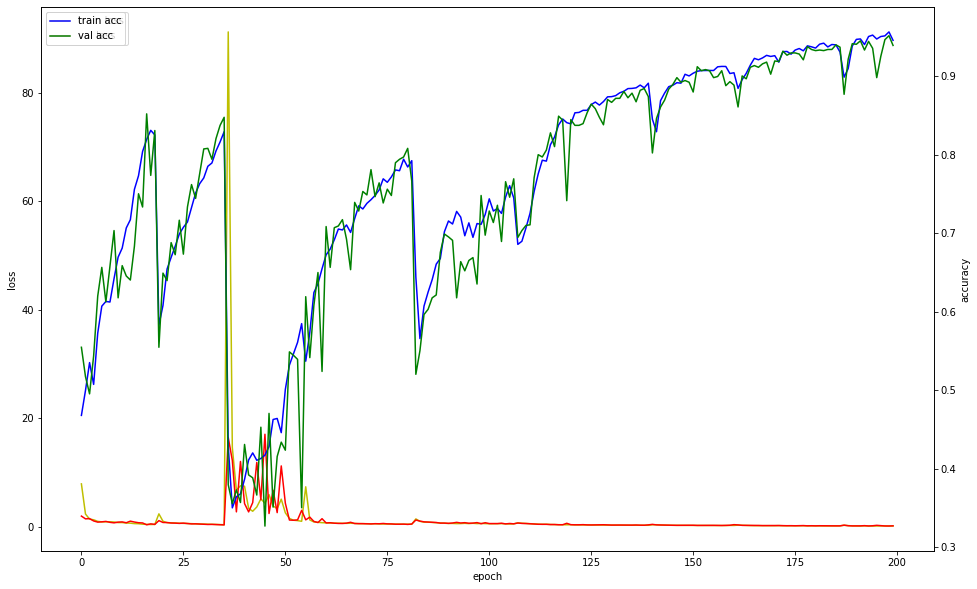

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[879,  31],
        [ 32, 424]],

       [[901,   2],
        [  5, 458]],

       [[886,  33],
        [ 29, 418]]])

In [10]:
result = model.evaluate(x_val, y_val, batch_size=100)
print('loss :', result[0])
print('test accuracy :', result[1])

14/14 [==============================] - 0s 17ms/step - loss: 0.1268 - acc: 0.9517
loss : 0.1268433779478073
test accuracy : 0.951683759689331
